Import & Path

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import nltk
import re
import pickle

In [2]:
# Set path
from google.colab import drive
drive.mount('/content/gdrive')
data_folder = '/content/gdrive/MyDrive/DD2424 Text Generation/Data/'
checkpoint_folder = '/content/gdrive/MyDrive/DD2424 Text Generation/Checkpoint/'
model_folder = '/content/gdrive/MyDrive/DD2424 Text Generation/Model/'
embedding_folder = '/content/gdrive/MyDrive/DD2424 Text Generation/embedding/'
history_folder = '/content/gdrive/MyDrive/DD2424 Text Generation/History/'

Mounted at /content/gdrive


Read & Process

Character level

In [3]:
# Read the database file
text = open(data_folder + 'shakespeare_full.txt', mode='r').read().lower()
print('Length of text: {} characters'.format(len(text)))
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)
# Map characters to their indices in vocabulary
input2index = {char: index for index, char in enumerate(vocab)}
# Map character indices to characters from vacabulary
index2input = np.array(vocab)
# Convert chars in text into indices
text_as_int = np.array([input2index[char] for char in text])
# Length of the vocabulary in chars.
vocab_size = len(vocab)
# One hot embedding
embedding_matrix = np.eye(vocab_size)
embedding_dim = vocab_size

Length of text: 4694778 characters
51 unique characters
vocab: ['\t', '\n', ' ', '!', '$', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Word level

In [ ]:
# Read the database file
text = open(data_folder + 'shakespeare_full.txt', mode='r').read().lower()
word_buffer = ''
delimiter = {'\t', '\n', ' ', '!', '$', "'", '(', ')', ',', '-', '.', ':', '?', '[', ']'}
vocab = {word for word in delimiter}
for i in text:
  if i in delimiter:
    if word_buffer != '' and word_buffer.lower() not in vocab:
      vocab.add(word_buffer.lower())
    if i == "'":
      word_buffer = "'"
    else:
      word_buffer = ''
  else:
    word_buffer += i
if word_buffer != '' and word_buffer.lower() not in vocab:
  vocab.add(word_buffer.lower())
vocab = sorted(vocab)
vocab_size = len(vocab)
# Map words to their indices in vocabulary
input2index = {word: index for index, word in enumerate(vocab)}
# Map indices to words from vacabulary
index2input = np.array(vocab)
# Convert words in text into indices
text_as_int = []
word_buffer = ''
for i in text:
  if i in delimiter:
    if word_buffer != '':
      text_as_int.append(input2index[word_buffer.lower()])
    if i == "'":
      word_buffer = "'"
    else:
      text_as_int.append(input2index[i])
      word_buffer = ''
  else:
    word_buffer += i
if word_buffer != '':
  text_as_int.append(input2index[word_buffer.lower()])
text_as_int = np.array(text_as_int)
print(len(text_as_int))
# Process the pre-trained word embedding
embeddings_index = {}
with open(embedding_folder + 'glove.6B.100d.txt') as f:
  for line in f:
    word, coefs = line.split(' ', 1)
    coefs = np.fromstring(coefs, "f", sep=' ')
    embeddings_index[word] = coefs    
    embedding_dim = len(coefs)
# Prepare embedding matrix
hits = 0
misses = 0
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for index, word in enumerate(vocab):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
    hits += 1
  else:
    misses += 1
    embedding_matrix[index] = np.random.uniform(size=embedding_dim) * 2 - 1.0
print("Converted %d words (%d misses)" % (hits, misses))

1965280
Converted 18013 words (5103 misses)


Create training sequences

In [4]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text
# The maximum length sentence we want for a single input in characters
sequence_length = 100
examples_per_epoch = len(text_as_int) // (sequence_length + 1)
# Create training dataset
int_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
# Generate batched sequences out of the char_dataset
sequences = int_dataset.batch(sequence_length + 1, drop_remainder=True)
dataset = sequences.map(split_input_target)
# Batch size
BATCH_SIZE = 64
# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
num_val = int(dataset.cardinality().numpy() * 0.1)
val_dataset = dataset.take(num_val) 
train_dataset = dataset.skip(num_val)

Build the model - Choose one of the three RNN layers

In [12]:
# Number of RNN units
rnn_units = 100
# RNN model
# Choose one of the three below

# LSTM
#rnn_layer_1 = tf.keras.layers.LSTM(units=rnn_units, return_sequences=True, stateful=True, recurrent_initializer=tf.keras.initializers.GlorotNormal())
#rnn_layer_2 = tf.keras.layers.LSTM(units=rnn_units, return_sequences=True, stateful=True, recurrent_initializer=tf.keras.initializers.GlorotNormal())
# Vanilla RNN
rnn_layer = tf.keras.layers.SimpleRNN(units=rnn_units, return_sequences=True, stateful=True, recurrent_initializer=tf.keras.initializers.GlorotNormal())
# GRU
#rnn_layer = tf.keras.layers.GRU(units=rnn_units, return_sequences=True, stateful=True, recurrent_initializer=tf.keras.initializers.GlorotNormal())

# Build the model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    batch_input_shape=[batch_size, None]
  ))
  model.add(rnn_layer)
  model.add(tf.keras.layers.Dense(vocab_size))
  return model

In [13]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 51)            2601      
                                                                 
 simple_rnn (SimpleRNN)      (64, None, 100)           15200     
                                                                 
 dense_2 (Dense)             (64, None, 51)            5151      
                                                                 
Total params: 22,952
Trainable params: 20,351
Non-trainable params: 2,601
_________________________________________________________________


Train the model

In [14]:
# The hyperparameters
learning_rate = 0.001
EPOCHS = 30

# Define the loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
# Define the optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)
# Name of the checkpoint files
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_folder + 'ckpt_{epoch}',
    save_weights_only=True
)
# Execute the training
history = model.fit(
    x=train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
) 

Epoch 1/30
654/654 [==============================] - 45s 65ms/step - loss: 2.4386 - val_loss: 2.1678
Epoch 2/30
654/654 [==============================] - 45s 66ms/step - loss: 2.0798 - val_loss: 2.0292
Epoch 3/30
654/654 [==============================] - 44s 65ms/step - loss: 1.9759 - val_loss: 1.9509
Epoch 4/30
654/654 [==============================] - 44s 65ms/step - loss: 1.9135 - val_loss: 1.9083
Epoch 5/30
654/654 [==============================] - 44s 65ms/step - loss: 1.8721 - val_loss: 1.8724
Epoch 6/30
654/654 [==============================] - 44s 65ms/step - loss: 1.8420 - val_loss: 1.8462
Epoch 7/30
654/654 [==============================] - 45s 66ms/step - loss: 1.8183 - val_loss: 1.8249
Epoch 8/30
654/654 [==============================] - 44s 65ms/step - loss: 1.7992 - val_loss: 1.8092
Epoch 9/30
654/654 [==============================] - 45s 66ms/step - loss: 1.7835 - val_loss: 1.7891
Epoch 10/30
654/654 [==============================] - 44s 65ms/step - loss: 1.769

Model Evaluation

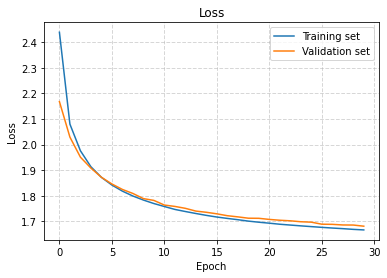

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

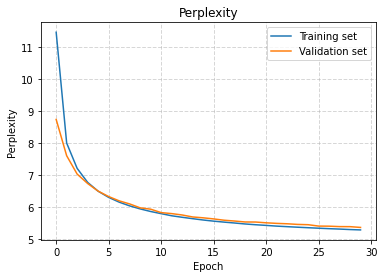

In [16]:
perplexity = tf.exp(loss)
val_perplexity = tf.exp(val_loss)
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.plot(perplexity, label='Training set')
plt.plot(val_perplexity, label='Validation set')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

In [17]:
with open(history_folder + 'history_char_rnn_100_full', 'wb') as f:
  pickle.dump(history.history, f)

Generate text

Load the latest checkpoint

In [10]:
model = build_model(vocab_size, embedding_dim, rnn_units, 1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_folder))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 51)             2601      
                                                                 
 gru_1 (GRU)                 (1, None, 100)            45900     
                                                                 
 dense_1 (Dense)             (1, None, 51)             5151      
                                                                 
Total params: 53,652
Trainable params: 51,051
Non-trainable params: 2,601
_________________________________________________________________


Generation Algorithm

In [ ]:
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def temperature_sampling(logits, temperature=1.0):
  predictions = logits / temperature
  return tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

# NUCLEUS SAMPLING
def nucleus_sampling(logits, p=0.95):
  exp_logits = np.exp(np.array(logits[-1, :]))
  probability = exp_logits / np.sum(exp_logits)
  probability_table = np.array([[i, probability[i]] for i in range(len(probability))])
  probability_table = probability_table[probability_table[:, 1].argsort()[::-1]]
  sum = 0.0
  pos = 0
  while sum < p:
    sum += probability_table[pos, 1]
    pos += 1
  distribution = np.zeros(len(probability))
  test_sum = 0.0
  for i in range(pos):
    distribution[int(probability_table[i, 0])] = probability_table[i, 1] / sum
  return np.random.choice(len(distribution), p=distribution)

# num_generate
# - number of characters to generate.
def generate_text(model, start_string, num_generate = 1000):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [input2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Temperature sampling
        predicted_id = temperature_sampling(predictions, temperature=0.9)

        # Nucleus sampling
        #predicted_id = nucleus_sampling(predictions, p=0.65)

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2input[predicted_id])

    return ''.join(text_generated)

Character level generation

In [ ]:
# Generate the text with default temperature (0.9).
print("romeo:\n" + generate_text(model, start_string=u"romeo:\n"))

romeo:
494169()268(6)(446)59462(549(()66)4(04229(91(84241(44349(6246)44484(1665(494604((49(5416((66444(81446$4866((66(6461(662(66644(9(4$(64(3(64((421(2214616646(6((1((949444644)944(414429688)1465)161(($(6(4(6(446264414(6)6(44(7274(166(6411(2696221246644)4462494456484((6436444264446426648942$8616(4(6(4(686626()(44644(62678446(4118(22146(616(6(11144(666624)4484566464$(6626(1244(4(846991(4268(641)6466414176441444(66646984(141211(468664()66494(42$44411((44198441414((47144((6664((16661)(445609666(6316642)6211444416961(6(2168664)4(4641462(446616149644(4494(94666(91(8464(4(6666414)41(968(664421666649644((4066(446(44444441664((841(54446644264(4446(466(6446(424636684(4146246666(86(644(((68(5(89(4((((641688(4446444616[224)(442168((181((6(2(((141(4346646444436(4444644(614(6264(626292(1664(9964(616194(4(9(41((462166126444(4466664184444(6664(462142491)26844966621188(2196461(4(1441444442666444226(104416(66446(21((4(4111489(4(42$6$46(2698644444426(68(44464(162446(429894(842916$)46(264666666416674662

Word level generation

In [ ]:
# Generate the text with default temperature (1.0).
print("romeo:\n" + generate_text(model, start_string=["romeo", ':', '\n']))

romeo: him:
barnardine,  mine ,all onthe the my
i the as putking way.
 my doubt count it  smile show
shall  good  arehis hear me.

duke my his , live. stay, undone , 
come.

sicinius:
here  son saythethy i .

petruchio:
why:
here terror, no first thourichard words andi
drum my :
aisthe thesee right speed suppose    him, patient
o.

montague:
and watch hoar, :

thou i  to' but at  angelo'd say all, good his be ago so chargewhere the thou learn,
be 'gainsthis andthis of his
your spirit your my you  he her for henryimy capulet a myself,  presently
or that a these thetake grief thou day. up he we is a then, art  :
bid time
let  sport fear,  pluck the  you let good.
now let anger's    true, to  lip,  would pray ofthough perceive is my my iit  forth, .

gremio:
where   myself  thou plain thou margaret:
ay, me, themgreat but been old late  love but or long not hate, is  oath .
that in  what hear you days 
whenout whata  brother   could :
rather  thou no for the bethink on this him, shall they

Save the model

In [18]:
model.save(model_folder + 'char_rnn_100_full')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DD2424 Text Generation/Model/char_rnn_100_full/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DD2424 Text Generation/Model/char_rnn_100_full/assets


Load saved model

In [ ]:
new_model = tf.keras.models.load_model(model_folder + 'word_lstm_100_ri_100')
# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 100)            1163200   
                                                                 
 lstm_1 (LSTM)               (1, None, 100)            80400     
                                                                 
 dense_1 (Dense)             (1, None, 11632)          1174832   
                                                                 
Total params: 2,418,432
Trainable params: 1,255,232
Non-trainable params: 1,163,200
_________________________________________________________________


In [ ]:
print("romeo:\n" + generate_text(new_model, start_string=["romeo", ':', '\n']))

romeo:   you my king  seeks as  more if toquit   my thene tongue grandfather  you done know  in be what think all this souls,  
o?
ithebear was for thou richard of  thee,  will andnot upproportion  lord,  thousand
thatold friend this devise you kind'd  not a  capuletthou me were of must'll  his fardel  to good it with  be    competitors do hare     me    night iof of would and  passage  :
  lord, 
where inreturn:
 not fearful thehis  :

lucio:
prithee is igross   then'd close it comfort, if loath a  rage;

menenius:

second had your  buttosea noblenessreft the't , it as man:
this been gentle lived,
  it,

hold my  the feed down proper'd doth  mine sick toe :
a  onebreaking, , of, 
andand leti my accusedthat 
or cousinis.
no speak so  it   set    meal not hour  and king   am ambitious.
again thee  was me!

gloucester:
the stranger:?
'twere am  dark.
iis us ruin  , thomas was   theyour  ere    you i  and more :

petruchio:
repair     word, cold  princes is  her king theof deadly best-.
a